# Import Packages

In [132]:
# Import packages
import os, subprocess
import pandas as pd
import torch.nn as nn
import random
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import WeightedRandomSampler


# Data Preparation & Data Cleaning

In [77]:
# Download data
if not os.path.exists('/content/train_data.zip'):
  subprocess.run(['wget', 'https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/train_data.zip'])
else:
  print('Training data already downloaded')
if not os.path.exists('/content/test_data.csv'):
  subprocess.run(['wget', 'https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/test_data.csv'])
else:
  print('Testing data already downloaded')
if not os.path.exists('/content/test_data_private.csv'):
  subprocess.run(['wget', 'https://git.stevensu.dev/lakewood999/cmsc472_finalproject/-/raw/main/test_data_private.csv'])
else:
  print('Truth data already downloaded')
# Extract data
if not os.path.exists('/content/train_data.csv'):
  subprocess.run(['unzip', 'train_data.zip'])
else:
  print('Data already extracted')

Training data already downloaded
Testing data already downloaded
Truth data already downloaded
Data already extracted


In [78]:
df = pd.read_csv('/content/train_data.csv')
df_test = pd.read_csv('/content/test_data.csv')
df_test_private = pd.read_csv('/content/test_data_private.csv')

In [79]:
# Rename the df_test_private true_risk to risk
df_test_private = df_test_private.rename(columns={'true_risk': 'risk'})

In [80]:
df_test_private['time_to_tca'].describe()

,time_to_tca
count,2167.000000
mean,0.198827
std,0.173507
min,-0.066980
25%,0.077967
50%,0.170928
75%,0.265111
max,0.977200


In [81]:
df_test = pd.concat([df_test, df_test_private])

In [82]:
SELECTED_INFO_COLUMNS = [
    'event_id', 'risk', 'time_to_tca'
]
SELECTED_FEATURE_COLUMNS = [
    'max_risk_scaling', 'max_risk_estimate', 'mahalanobis_distance', 'miss_distance',
    'relative_position_r', 'relative_position_t', 'relative_position_n',
    'relative_velocity_r', 'relative_velocity_t', 'relative_velocity_n',
    'c_weighted_rms', 't_weighted_rms', 'c_sigma_tdot', 't_span', 't_j2k_inc', 'c_j2k_inc', 'c_sigma_r',
    'c_crdot_t', 'c_sigma_n', 'c_sigma_t', 'c_position_covariance_det', 't_position_covariance_det'
]
ALL_SELECTED_COLUMNS = SELECTED_INFO_COLUMNS + SELECTED_FEATURE_COLUMNS
df_training_reduced = df.loc[:, ALL_SELECTED_COLUMNS]
df_test_reduced = df_test.loc[:, ALL_SELECTED_COLUMNS]
df_training_reduced['dataset'] = 'train'
df_test_reduced['dataset'] = 'test'
df_test_reduced['event_id'] = df_training_reduced['event_id'].max() + df_test_reduced['event_id'] + 10000000
# Combine the training and test data
df_reduced = pd.concat([df_training_reduced, df_test_reduced])
# Make all feature columns numeric
df_reduced[SELECTED_FEATURE_COLUMNS] = df_reduced[SELECTED_FEATURE_COLUMNS].apply(pd.to_numeric)
print("Train events:", len(df_reduced[df_reduced['dataset'] == 'train']['event_id'].unique()))
print("Test events:", len(df_reduced[df_reduced['dataset'] == 'test']['event_id'].unique()))
# assert no overlaps in train and test event ids
assert len(set(df_reduced[df_reduced['dataset'] == 'train']['event_id'].unique()) & set(df_reduced[df_reduced['dataset'] == 'test']['event_id'].unique())) == 0
df_reduced.head(n=5)
#df_reduced[df_reduced['dataset'] == 'test']['event_id'].unique()

Train events: 13154
Test events: 2167


,event_id,risk,time_to_tca,max_risk_scaling,max_risk_estimate,mahalanobis_distance,miss_distance,relative_position_r,relative_position_t,relative_position_n,...,t_span,t_j2k_inc,c_j2k_inc,c_sigma_r,c_crdot_t,c_sigma_n,c_sigma_t,c_position_covariance_det,t_position_covariance_det,dataset
0,0,-10.204955,1.566798,8.602101,-7.834756,129.430951,14923.0,453.8,5976.6,-13666.8,...,1.0,97.806412,74.045735,266.722309,-0.999998,46.612573,54366.864909,4.429923e+16,737347.125225,train
1,0,-10.355758,1.207494,8.956374,-7.848937,271.540424,14544.0,474.3,5821.2,-13319.8,...,1.0,97.806420,74.045736,262.191819,-0.999998,46.595869,54082.067268,4.378610e+16,114138.993569,train
2,0,-10.345631,0.952193,8.932195,-7.847406,347.899292,14475.0,474.6,5796.2,-13256.1,...,1.0,97.806418,74.045737,261.666544,-0.999998,46.592757,54027.391201,4.369105e+16,46960.041117,train
3,0,-10.337809,0.579669,8.913444,-7.845880,435.376626,14579.0,472.7,5838.9,-13350.7,...,1.0,97.806423,74.045736,261.759718,-0.999998,46.597586,54107.605750,4.382408e+16,12454.776555,train
4,0,-10.391260,0.257806,9.036838,-7.852942,469.178802,14510.0,478.7,5811.1,-13288.0,...,1.0,97.806426,74.045736,260.727425,-0.999998,46.594699,54063.675421,4.374142e+16,7827.098153,train


In [83]:
# Data cleaning
def extract_means(df, columns):
  '''For each column, extract the mean and std dev. values'''
  means = {}
  stds = {}
  for column in columns:
    means[column] = df[column].mean()
    stds[column] = df[column].std()
  return means, stds
def standardize_column(df, means, stds):
  '''For each column, standardize to 0 mean and 1 std, returning the values needed to do so'''
  for column in means.keys():
    df[column] = (df[column] - means[column]) / stds[column]
  return df
def extract_max(df, columns):
  '''For each column, extract the max value'''
  maxes = {}
  for column in columns:
    maxes[column] = df[column].max()
  return maxes
def scale_columns(df, maxes):
  '''For each column, scale to 0-1'''
  for column in maxes.keys():
    df[column] = df[column] / maxes[column]
  return df

#means, stds = extract_means(df_reduced[df_reduced['dataset'] == 'train'], SELECTED_FEATURE_COLUMNS)
#df_std = standardize_column(df_reduced, means, stds)
maxes = extract_max(df_reduced[df_reduced['dataset'] == 'train'], SELECTED_FEATURE_COLUMNS)
df_std = scale_columns(df_reduced, maxes)

# Sort
df_std = df_std.sort_values(by=['event_id', 'time_to_tca'])
df_std["event_id"] = df_std["event_id"].astype(str)

# Backfill missing data with the previous entry in each event_id for each columns
# Sanity check that event_id and dataset don't have NAs
assert df_std["event_id"].isna().sum() == 0
assert df_std["dataset"].isna().sum() == 0
df_std = df_std.groupby('event_id', group_keys=False).apply(
  lambda x: x.apply(lambda y: y.fillna(method='ffill', axis=0))
)
# Then fill with the mean
df_std = df_std.apply(
  lambda x: x.fillna(x.mean(skipna=True) if x.dtype == 'float64' else x.mode()[0])
)
df_std.head(n=5)

df_final = df_std.copy()

<ipython-input-83-32af022704af>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.apply(lambda y: y.fillna(method='ffill', axis=0))
<ipython-input-83-32af022704af>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_std = df_std.groupby('event_id', group_keys=False).apply(


12745
{'5319': 23, '7088': 23, '11942': 23, '4377': 22, '4378': 22, '12327': 22, '12923': 22, '10271': 22, '12594': 22, '7536': 22, '5895': 22, '5930': 22, '2549': 22, '5087': 22, '12008': 22, '9347': 22, '3208': 22, '10280': 22, '7765': 22, '6612': 22, '7814': 22, '5032': 22, '12909': 22, '9833': 22, '12611': 22, '339': 22, '7845': 22, '7287': 22, '1509': 22, '1521': 22, '11661': 22, '661': 22, '681': 22, '10760': 22, '3825': 22, '9482': 22, '9491': 22, '3949': 22, '11745': 22, '5253': 22, '7986': 22, '12517': 22, '3904': 22, '7949': 22, '1531': 22, '9777': 22, '1839': 22, '11161': 22, '12950': 22, '3138': 22, '5126': 22, '1576': 22, '6655': 22, '3852': 22, '10728': 22, '278': 22, '6690': 22, '1902': 22, '7903': 22, '9396': 22, '5152': 22, '10309': 22, '2632': 22, '2631': 22, '220': 22, '9430': 22, '4315': 22, '2597': 22, '2255': 22, '9097': 22, '10871': 22, '7462': 22, '6268': 22, '7583': 22, '12145': 22, '4458': 22, '6227': 22, '6221': 22, '12215': 22, '10063': 22, '3498': 22, '1280

<Axes: >

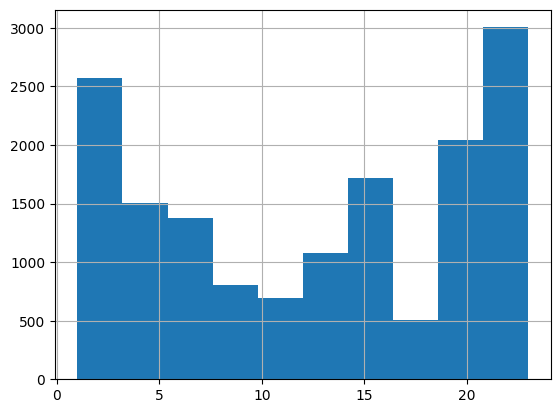

In [84]:
# Find how many entries we have per event_id and the average length
event_counts = df_final['event_id'].value_counts()
event_counts_per_id = event_counts.to_dict()
ids_sufficient_length = event_counts[(event_counts > 3)]
print(len(ids_sufficient_length))
print(event_counts_per_id)
print(event_counts.describe())
event_counts.hist()

In [85]:
# Count the number of events with series length n
counts = event_counts.value_counts()
print(counts.sort_index())
# Extract events with only length 1
debug = df_final[df_final['event_id'].isin(event_counts[event_counts == 1].index)]
debug.head(n=5)

count
1      225
2     1273
3     1078
4      818
5      689
6      717
7      662
8      366
9      443
10     362
11     333
12     349
13     343
14     387
15     711
16    1011
17     258
18     246
19     494
20    1551
21    2810
22     192
23       3
Name: count, dtype: int64


,event_id,risk,time_to_tca,max_risk_scaling,max_risk_estimate,mahalanobis_distance,miss_distance,relative_position_r,relative_position_t,relative_position_n,...,t_span,t_j2k_inc,c_j2k_inc,c_sigma_r,c_crdot_t,c_sigma_n,c_sigma_t,c_position_covariance_det,t_position_covariance_det,dataset
1346,100,-14.562091,0.033885,1.204916e-15,7.200122,2.246218e-08,0.328054,-0.081584,0.174171,-0.377702,...,0.328401,0.888649,0.673104,9.533551e-08,-2.544273,1.153605e-07,3.169038e-06,9.262252e-40,1.000000e+00,train
2048,161,-30.000000,1.710535,1.567397e-06,6.054619,1.444379e-02,0.701809,-0.095910,-0.704503,-0.348730,...,0.757849,0.993666,0.596784,4.611461e-06,-2.544271,7.799789e-07,5.341551e-05,4.183670e-32,3.747633e-42,train
4109,327,-30.000000,0.252113,5.938061e-05,4.230757,5.025277e-03,0.037211,-0.022331,0.040256,0.001828,...,0.757849,0.993809,0.682638,1.477726e-07,-2.500305,2.438052e-07,4.064525e-07,2.729780e-40,1.457975e-43,train
4329,344,-30.000000,0.705067,8.707719e-04,6.137420,8.583317e-02,0.381043,-0.043470,-0.059103,0.498210,...,0.757849,0.994156,0.596459,4.435434e-07,-2.500305,2.923748e-07,8.416815e-06,1.459054e-36,3.785421e-43,train
4437,356,-25.088949,4.812914,1.052936e-06,4.210116,8.703387e-04,0.027800,0.033705,0.012235,-0.033398,...,0.148683,0.997158,0.461939,4.352682e-07,-2.542424,5.264692e-07,6.791948e-06,2.855896e-36,2.150700e-39,train


In [86]:
# Figure out the smallest time_to_tca for each event id
min_time_to_tca = df_final.groupby('event_id')['time_to_tca'].min().to_dict()
max_time_to_tca = df_final.groupby('event_id')['time_to_tca'].max().to_dict()
print(min_time_to_tca)
print(max_time_to_tca)

{'0': 0.2578060416666667, '1': 3.570013078703704, '10': 0.2975132523148148, '100': 0.0338845601851851, '1000': 0.2057198379629629, '10000': 0.2292499768518518, '10001': 0.0503764236111111, '10002': 0.204375162037037, '10003': 0.2410364814814815, '10004': 0.1874918055555556, '10005': 0.8624335763888888, '10006': 0.0356541087962963, '10007': 0.3865327893518519, '10008': 4.802082094907409, '10009': 0.0556134837962963, '1001': 5.249447638888889, '10010': 1.0210280324074077, '10011': 5.945260439814816, '10012': 0.0835118981481481, '10013': 1.6435947569444445, '10013153': 0.2641084953703704, '10013154': 0.2145857060185185, '10013155': 0.1332855324074074, '10013156': 0.1810332754629629, '10013157': 0.0224919328703703, '10013158': 0.2261986458333333, '10013159': 0.1157168402777778, '10013160': 0.1438317824074074, '10013161': 0.3059663888888889, '10013162': 0.2049696875, '10013163': 0.2590693518518519, '10013164': 0.0413687152777777, '10013165': 0.2239914467592592, '10013166': 0.112579745370370

In [87]:
# Pre-separate and prepare data
all_event_ids = df_final['event_id'].unique()
individual_event_dfs = {
    x:y for x, y in df_final.groupby('event_id')
}
for i in individual_event_dfs:
    individual_event_dfs[i] = individual_event_dfs[i].sort_values(by=['time_to_tca'], ascending=False)

# Break out all of the features and prepare into lists
selected_features = SELECTED_FEATURE_COLUMNS + ['time_to_tca']  # Removed 'risk'
all_features_complete = {} # store original features
all_features = {} # keep only time_to_tca >= 2
all_labels = {}
all_baseline_labels = {}
all_baseline_labels_no_tca = {}
event_counts_per_id = {}
for i in individual_event_dfs:
  event_df = individual_event_dfs[i]
  # All features (no tca consideration)
  features = event_df[selected_features].values[:-1]
  # All features (min tca enforced)
  event_df_truncated = event_df[:-1][event_df[:-1]['time_to_tca'] >= 2]
  features_truncated = event_df_truncated[selected_features].values
  all_features[i] = torch.tensor(features_truncated, dtype=torch.float32)
  all_features_complete[i] = torch.tensor(features, dtype=torch.float32)
  event_counts_per_id[i] = len(event_df_truncated)
  # Label (independent of tca)
  label = event_df['risk'].values[-1]
  baseline_label = event_df_truncated['risk'].values[-1] if len(event_df_truncated) >= 1 else 0
  baseline_label_no_tca = event_df['risk'].values[-2] if len(event_df) >= 2 else 0
  all_labels[i] = torch.tensor(label, dtype=torch.float32)
  all_baseline_labels[i] = torch.tensor(baseline_label, dtype=torch.float32)
  all_baseline_labels_no_tca[i] = torch.tensor(baseline_label_no_tca, dtype=torch.float32)

In [88]:
df_final[df_final['dataset'] == 'test']['event_id'].unique()

array(['10013153', '10013157', '10013156', ..., '10015318', '10015317',
       '10015316'], dtype=object)

In [89]:
# test starts at 10013153
target_id = "10013153"
print(all_labels[target_id])
event_df = individual_event_dfs[target_id]
event_df[:-1][event_df[:-1]['time_to_tca'] >= 2].head(n=10)

tensor(-7.3225)


,event_id,risk,time_to_tca,max_risk_scaling,max_risk_estimate,mahalanobis_distance,miss_distance,relative_position_r,relative_position_t,relative_position_n,...,t_span,t_j2k_inc,c_j2k_inc,c_sigma_r,c_crdot_t,c_sigma_n,c_sigma_t,c_position_covariance_det,t_position_covariance_det,dataset
0,10013153,-7.296967,6.842095,3.588003e-08,6.659887,0.003376,0.472237,-0.069170,0.433663,0.331013,...,0.054132,0.993623,0.51228,0.000003,-2.545341,7.115977e-07,0.000368,7.148004e-31,1.150901e-39,test
1,10013153,-7.282496,6.571818,3.530794e-08,6.651472,0.003360,0.461535,-0.068470,0.423847,0.323495,...,0.054132,0.993623,0.51228,0.000003,-2.545340,7.122279e-07,0.000366,7.059441e-31,1.106976e-39,test
2,10013153,-7.316053,6.112986,3.660990e-08,6.668150,0.004141,0.477966,-0.070154,0.438928,0.335023,...,0.054132,0.993623,0.51228,0.000003,-2.545341,7.112686e-07,0.000369,7.179219e-31,8.647230e-40,test
3,10013153,-7.334138,5.921955,3.743538e-08,6.678147,0.004358,0.488000,-0.071214,0.448144,0.342057,...,0.054132,0.993623,0.51228,0.000003,-2.545342,7.106852e-07,0.000371,7.254316e-31,8.404644e-40,test
4,10013153,-7.332267,2.228761,3.738985e-08,6.676858,0.016892,0.486723,-0.071081,0.446958,0.341186,...,0.054132,0.993623,0.51228,0.000003,-2.545341,7.107550e-07,0.000370,7.217121e-31,1.706614e-41,test


In [90]:
# Separate event ids
test_ids = df_final[df_final['dataset'] == 'test']['event_id'].unique()
non_test_ids = df_final[df_final['dataset'] == 'train']['event_id'].unique()
assert len(set(test_ids) - set(non_test_ids)) == len(set(test_ids))
# Filter out bad data
non_test_ids_filtered = [x for x in non_test_ids if event_counts_per_id[x] >= 2]
non_test_ids_filtered = [x for x in non_test_ids_filtered if min_time_to_tca[x] <= 2]
non_test_ids_filtered = [x for x in non_test_ids_filtered if all_features[x].shape[0] > 0]
high_risk_train_ids = []
low_risk_train_ids = []
for i in non_test_ids_filtered:
  if all_labels[i] >= -6:
    high_risk_train_ids.append(i)
  else:
    low_risk_train_ids.append(i)
print(f"# test ids: {len(test_ids)}, # train ids: {len(non_test_ids_filtered)}, # high-risk train: {len(high_risk_train_ids)}, # low-risk train: {len(low_risk_train_ids)}")

# Find anomalous high-risk entries
anomalous_low_to_high = []
non_anomalous_high_to_high = []
anomalous_high_to_low = []
non_anomalous_low_to_low = []
for x in non_test_ids_filtered:
  if all_baseline_labels[x] < -6 and all_labels[x] >= -6:
    anomalous_low_to_high.append(x)
  elif all_baseline_labels[x] >= -6 and all_labels[x] >= -6:
    non_anomalous_high_to_high.append(x)
  elif all_baseline_labels[x] < -6 and all_labels[x] < -6:
    non_anomalous_low_to_low.append(x)
  elif all_baseline_labels[x] >= -6 and all_labels[x] < -6:
    anomalous_high_to_low.append(x)
print(len(anomalous_low_to_high))
print(len(non_anomalous_high_to_high))
print(len(anomalous_high_to_low))
print(len(non_anomalous_low_to_low))

# test ids: 2167, # train ids: 8413, # high-risk train: 83, # low-risk train: 8330
18
65
241
8089


In [91]:
import random
random.seed(42)
# Trandom sample from each set of data
ratio = 0.8
train_ids = random.sample(anomalous_low_to_high, int(len(anomalous_low_to_high) * ratio)) + \
            random.sample(non_anomalous_high_to_high, int(len(non_anomalous_high_to_high) * ratio)) \
            + random.sample(anomalous_high_to_low, int(len(anomalous_high_to_low) * ratio)) \
            + random.sample(non_anomalous_low_to_low, int(len(non_anomalous_low_to_low) * ratio))
val_ids = list(set(anomalous_low_to_high) - set(train_ids)) + list(set(non_anomalous_high_to_high) - set(train_ids)) + \
          list(set(anomalous_high_to_low) - set(train_ids)) + list(set(non_anomalous_low_to_low) - set(train_ids))
print(f"# train ids: {len(train_ids)}, # val ids: {len(val_ids)}")

# train ids: 6729, # val ids: 1684


In [92]:
train_low_subset = [x for x in train_ids if x in anomalous_low_to_high + non_anomalous_low_to_low]
val_low_subset = [x for x in val_ids if x in anomalous_low_to_high + non_anomalous_low_to_low]
print(f"# train high subset: {len(train_low_subset)}, # val high subset: {len(val_low_subset)}")

# train high subset: 6485, # val high subset: 1622


In [107]:
# Custom DataLoader for Time Series Transformer (TST)

import random
import torch
from torch.nn.utils.rnn import pad_sequence

class CustomTSTDataLoader(object):
    def __init__(self, ids, all_features, all_labels, batch_size, shuffle=True, oversample_ids=None, oversample_factor=4):
        self.ids = ids
        self.all_features = all_features
        self.all_labels = all_labels
        self.oversample_ids = oversample_ids
        self.oversample_factor = oversample_factor
        self.batch_size = batch_size
        self.shuffle = shuffle
        self._make_batches()

    def __len__(self):
        return len(self.batches)

    def _make_batches(self):
        # Prepare batches with samples of same length
        batches = []
        relevant_ids = self.ids

        # Handle oversampling for balancing high-risk samples
        if self.oversample_ids is not None:
            additional_ids = [x for x in self.oversample_ids if x in relevant_ids]
            relevant_ids = relevant_ids + additional_ids * self.oversample_factor

        # Shuffle IDs if required
        if self.shuffle:
            random.shuffle(relevant_ids)

        # Create batches
        for i in range(0, len(relevant_ids), self.batch_size):
            batch = []
            for j in range(i, min(i + self.batch_size, len(relevant_ids))):
                batch.append(relevant_ids[j])
            batches.append(batch)

        # Shuffle batches if required
        if self.shuffle:
            random.shuffle(batches)

        self.batches = batches

    def _pad_and_mask(self, features_list):
        # Pad sequences to the same length in the batch
        padded_features = pad_sequence(features_list, batch_first=True)  # Shape: [batch_size, max_seq_length, num_features]

        # Create an attention mask where 1 indicates valid positions (non-padded)
        attention_masks = torch.zeros(padded_features.shape[0], padded_features.shape[1])
        for idx, features in enumerate(features_list):
            attention_masks[idx, :features.shape[0]] = 1

        return padded_features, attention_masks

    def _gen_bucketed_batches(self):
        for batch in self.batches:
            # Prepare features and labels in shape (batch_size, sequence_length, num_features)
            features = []
            labels = []
            for i in batch:
                features.append(self.all_features[i])
                labels.append(self.all_labels[i])

            # Pad features and create attention masks
            padded_features, attention_masks = self._pad_and_mask(features)

            # Stack labels to create a batch tensor for labels
            labels = torch.stack(labels)

            yield padded_features, attention_masks, labels

    def __iter__(self):
        self._make_batches()
        return self._gen_bucketed_batches()


# Creation of model and training


In [167]:
# Create DataLoader instances
train_loader = CustomTSTDataLoader(
    train_ids, all_features, all_labels, batch_size=32, shuffle=True,
    oversample_ids=high_risk_train_ids, oversample_factor=10  # Increased factor
)
val_loader = CustomTSTDataLoader(val_ids, all_features, all_labels, batch_size=32, shuffle=False)


In [168]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        self.positional_encoding = self._generate_positional_encoding(max_seq_len, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layers for regression and classification
        self.regression_head = nn.Linear(model_dim, 1)  # Predicts 'risk' value
        self.classification_head = nn.Linear(model_dim, 1)  # Predicts probability of high-risk

    def _generate_positional_encoding(self, max_seq_len, model_dim):
        positional_encoding = torch.zeros(max_seq_len, model_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding.unsqueeze(0)
        return nn.Parameter(positional_encoding, requires_grad=False)

    def forward(self, x, attention_mask):
        batch_size, seq_len, _ = x.size()
        x = self.input_projection(x)
        x = x + self.positional_encoding[:, :seq_len, :]
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x, src_key_padding_mask=attention_mask == 0)
        x = x.transpose(0, 1)
        x = torch.mean(x, dim=1)

        # Regression output
        risk_output = self.regression_head(x).squeeze()

        # Classification output
        classification_output = self.classification_head(x).squeeze()

        return risk_output, classification_output


# def ESALoss(x, y):
#     x = x.squeeze()
#     y = y.squeeze()

#     # Use sigmoid to create differentiable approximations of the indicator function
#     # Adjust the multiplier (e.g., 10, 20) to control the steepness
#     x_prob = torch.sigmoid(10 * (x + 6))
#     y_prob = torch.sigmoid(10 * (y + 6))

#     # Compute "soft" true positives, false positives, and false negatives
#     tp = torch.sum(x_prob * y_prob)
#     fp = torch.sum(x_prob * (1 - y_prob))
#     fn = torch.sum((1 - x_prob) * y_prob)

#     # Avoid division by zero
#     epsilon = 1e-10
#     tp = tp + epsilon
#     fp = fp + epsilon
#     fn = fn + epsilon

#     # Compute precision and recall
#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)

#     # Compute F2 score
#     f2 = 5 * precision * recall / (4 * precision + recall + epsilon)

#     # Compute MSE weighted by y_prob (gives more emphasis to high-risk samples)
#     mse = torch.mean(((x - y) ** 2) * y_prob)

#     # Return the loss
#     loss = (1 / f2) * mse

#     return loss


# def CustomMSE(x, y):
#     x = x.squeeze()
#     y = y.squeeze()
#     # Identify high-risk samples
#     y_bool = y >= -6
#     # Compute MSE with different penalties
#     if torch.sum(y_bool) > 0:
#         mse_high = (x[y_bool] - y[y_bool]) ** 4
#     else:
#         mse_high = torch.tensor(0.0, device=x.device)
#     if torch.sum(~y_bool) > 0:
#         mse_low = (x[~y_bool] - y[~y_bool]) ** 2
#     else:
#         mse_low = torch.tensor(0.0, device=x.device)
#     # Combine and compute mean
#     total_mse = (torch.sum(mse_high) + torch.sum(mse_low)) / len(x)
#     return total_mse

# def WeightedMSELoss(x, y):
#     x = x.squeeze()
#     y = y.squeeze()
#     # Calculate weights
#     y_bool = y >= -6
#     weights = torch.where(y_bool, torch.tensor(10.0, device=y.device), torch.tensor(1.0, device=y.device))
#     # Compute weighted MSE
#     loss = torch.mean(weights * (x - y) ** 2)
#     return loss


import torch.nn.functional as F

def combined_loss(risk_pred, class_pred, risk_true, alpha=1.0, beta=1.0, pos_weight=None):
    mse_loss = F.mse_loss(risk_pred, risk_true)
    class_true = (risk_true >= -6).float()
    bce_loss = F.binary_cross_entropy_with_logits(class_pred, class_true, pos_weight=pos_weight)
    # Penalize false positives
    false_positive_penalty = torch.mean(torch.sigmoid(class_pred)[class_true == 0])
    total_loss = alpha * mse_loss + beta * (bce_loss + false_positive_penalty)
    return total_loss, mse_loss.item(), bce_loss.item()


# Define hyperparameters and create model instance
input_dim = len(selected_features)
model_dim = 128
num_heads = 4
num_layers = 3
output_dim = 1
max_seq_len = max([len(all_features[i]) for i in all_features])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimeSeriesTransformer(
    input_dim=input_dim,
    model_dim=model_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim,
    max_seq_len=max_seq_len
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


- **Training**

In [169]:
import torch.optim as optim

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and move it to the device
model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers, output_dim, max_seq_len).to(device)

# Define loss function and optimizer
criterion = combined_loss  # Use ESALoss
# criterion = CustomMSE

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [170]:
def train_one_epoch(model, data_loader, optimizer, device, alpha=1.0, beta=1.0, pos_weight=None):
    model.train()
    running_loss = 0.0
    running_mse_loss = 0.0
    running_bce_loss = 0.0
    all_labels_list = []
    all_predictions_list = []
    all_class_preds_list = []

    for padded_features, attention_masks, labels in data_loader:
        padded_features = padded_features.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        # Forward pass
        risk_outputs, class_outputs = model(padded_features, attention_masks)
        loss, mse_loss_value, bce_loss_value = combined_loss(
            risk_outputs, class_outputs, labels, alpha, beta, pos_weight=pos_weight
        )

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse_loss += mse_loss_value
        running_bce_loss += bce_loss_value

        # Collect labels and predictions for metrics
        all_labels_list.extend(labels.cpu().numpy())
        all_predictions_list.extend(risk_outputs.detach().cpu().numpy())

        # Apply sigmoid to classification outputs to get probabilities
        class_probs = torch.sigmoid(class_outputs)
        all_class_preds_list.extend(class_probs.detach().cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    avg_mse_loss = running_mse_loss / len(data_loader)
    avg_bce_loss = running_bce_loss / len(data_loader)

    # Compute metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    y_true_bin = np.array(all_labels_list) >= -6
    y_pred_bin = np.array(all_class_preds_list) >= 0.5  # Adjust threshold if needed

    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    precision, recall, _, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, average='binary', zero_division=0
    )

    return avg_loss, avg_mse_loss, avg_bce_loss, accuracy, precision, recall

def validate_one_epoch(model, data_loader, device, alpha=1.0, beta=1.0, pos_weight=None):
    model.eval()
    val_loss = 0.0
    val_mse_loss = 0.0
    val_bce_loss = 0.0
    all_labels_list = []
    all_predictions_list = []
    all_class_preds_list = []

    with torch.no_grad():
        for padded_features, attention_masks, labels in data_loader:
            padded_features = padded_features.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Forward pass
            risk_outputs, class_outputs = model(padded_features, attention_masks)
            loss, mse_loss_value, bce_loss_value = combined_loss(
                risk_outputs, class_outputs, labels, alpha, beta, pos_weight=pos_weight
            )

            val_loss += loss.item()
            val_mse_loss += mse_loss_value
            val_bce_loss += bce_loss_value

            # Collect labels and predictions for metrics
            all_labels_list.extend(labels.cpu().numpy())
            all_predictions_list.extend(risk_outputs.cpu().numpy())

            # Apply sigmoid to classification outputs to get probabilities
            class_probs = torch.sigmoid(class_outputs)
            all_class_preds_list.extend(class_probs.cpu().numpy())

    avg_val_loss = val_loss / len(data_loader)
    avg_val_mse_loss = val_mse_loss / len(data_loader)
    avg_val_bce_loss = val_bce_loss / len(data_loader)

    # Compute metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    y_true_bin = np.array(all_labels_list) >= -6
    y_pred_bin = np.array(all_class_preds_list) >= 0.5  # Adjust threshold if needed

    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    precision, recall, _, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, average='binary', zero_division=0
    )

    return avg_val_loss, avg_val_mse_loss, avg_val_bce_loss, accuracy, precision, recall


In [171]:
# Create DataLoader instances for train and validation
train_loader = CustomTSTDataLoader(train_ids, all_features, all_labels, batch_size=32, shuffle=True, oversample_ids=high_risk_train_ids)
val_loader = CustomTSTDataLoader(val_ids, all_features, all_labels, batch_size=32, shuffle=False)

# Training loop
num_epochs = 20
alpha = 1.0  # Weight for regression loss
beta = 5.0   # Weight for classification loss

# Before training loop
num_positive = sum([1 for i in train_ids if all_labels[i].item() >= -6])
num_negative = len(train_ids) - num_positive
pos_weight_value = num_negative / num_positive
pos_weight = torch.tensor([pos_weight_value], device=device)

# Cap the pos_weight value
max_pos_weight = 10.0  # Adjust as needed
pos_weight_value = min(num_negative / num_positive, max_pos_weight)
pos_weight = torch.tensor([pos_weight_value], device=device)


for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_mse_loss, train_bce_loss, train_accuracy, train_precision, train_recall = train_one_epoch(
        model, train_loader, optimizer, device, alpha, beta, pos_weight=pos_weight
    )

    # Validate for one epoch
    val_loss, val_mse_loss, val_bce_loss, val_accuracy, val_precision, val_recall = validate_one_epoch(
        model, val_loader, device, alpha, beta, pos_weight=pos_weight
    )

    # Print losses and metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {train_loss:.4f} (MSE: {train_mse_loss:.4f}, BCE: {train_bce_loss:.4f})")
    print(f"Training Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
    print(f"Validation Loss: {val_loss:.4f} (MSE: {val_mse_loss:.4f}, BCE: {val_bce_loss:.4f})")
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}\n")


Epoch [1/20]
Training Loss: 157.8628 (MSE: 151.9132, BCE: 0.9644)
Training Accuracy: 0.9421, Precision: 0.0690, Recall: 0.0182
Validation Loss: 51.9257 (MSE: 48.8625, BCE: 0.3946)
Validation Accuracy: 0.9899, Precision: 0.0000, Recall: 0.0000

Epoch [2/20]
Training Loss: 70.5510 (MSE: 64.5725, BCE: 0.9832)
Training Accuracy: 0.9471, Precision: 0.0652, Recall: 0.0091
Validation Loss: 51.6260 (MSE: 48.7495, BCE: 0.3793)
Validation Accuracy: 0.9899, Precision: 0.0000, Recall: 0.0000

Epoch [3/20]
Training Loss: 71.0910 (MSE: 65.0971, BCE: 0.9809)
Training Accuracy: 0.9528, Precision: 0.0000, Recall: 0.0000
Validation Loss: 51.0302 (MSE: 48.6619, BCE: 0.3413)
Validation Accuracy: 0.9899, Precision: 0.0000, Recall: 0.0000

Epoch [4/20]
Training Loss: 70.9213 (MSE: 64.9200, BCE: 0.9840)
Training Accuracy: 0.9484, Precision: 0.0303, Recall: 0.0030
Validation Loss: 51.8567 (MSE: 48.5339, BCE: 0.4194)
Validation Accuracy: 0.9899, Precision: 0.0000, Recall: 0.0000

Epoch [5/20]
Training Loss: 70

In [172]:
torch.save(model.state_dict(), "tst_model.pth")
print("Model saved as tst_model.pth")

Model saved as tst_model.pth


# Testing
